# Assignment 3: Classifiers, Object Recognition
### Samantha Handal - 260983914

## 1 - CIFAR10 Classification using SVM and Random Forest

import dataset from CIFAR10 (setup)

In [1]:
import pickle
import numpy as np
import cv2
from skimage.feature import hog
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

from google.colab import drive
drive.mount('/content/drive')

# Setting up the path variable
path = '/content/drive/My Drive/ECSE415/Assignment_3/A3-W24-images/'

# Load CIFAR10 dataset
def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

# Paths to the dataset files
batch_files = [path + 'cifar-10-batches-py/data_batch_1', path + 'cifar-10-batches-py/data_batch_2', path + 'cifar-10-batches-py/data_batch_3',
               path + 'cifar-10-batches-py/data_batch_4', path + 'cifar-10-batches-py/data_batch_5']
test_file = path + 'cifar-10-batches-py/test_batch'
meta_file = path + 'cifar-10-batches-py/batches.meta'

# Load training data
x_train, y_train = [], []
for file in batch_files:
    batch = unpickle(file)
    x_train.append(batch[b'data'])
    y_train += batch[b'labels']
x_train = np.vstack(x_train).reshape(-1, 3, 32, 32).transpose(0,2,3,1) # Convert to HWC format
y_train = np.array(y_train)

# Load test data
test_batch = unpickle(test_file)
x_test = test_batch[b'data'].reshape(-1, 3, 32, 32).transpose(0,2,3,1) # Convert to HWC format
y_test = np.array(test_batch[b'labels'])

# Load label names
meta_dict = unpickle(meta_file)
label_names = [label.decode('utf-8') for label in meta_dict[b'label_names']]

Mounted at /content/drive


### 1.2 - Resize & Compute HoG
the train/test images to 64x64 and convert them to grayscale images. Compute HoG features with cells of 8x8 pixels, blocks of 4x4 cells, and 4 bins. This should generate a feature vector of size 1600 per image, which can be regarded as features for training classifiers.

Ref: Tutorial 6

In [5]:
### Resize to reduec computational load ###

# Calculate the indices for slicing 70% of the data
train_index = int(len(x_train) * 0.1)
test_index = int(len(x_test) * 0.1)

# Slice the arrays to include only the first 70% of the data
x_train_small = x_train[:train_index]
x_test_small = x_test[:test_index]

# Slice the labels to match the sliced image data
y_train_small = y_train[:train_index]
y_test_small = y_test[:test_index]

# Resize and convert to grayscale
x_train_gray = np.array([cv2.cvtColor(cv2.resize(img, (64, 64)), cv2.COLOR_RGB2GRAY) for img in x_train_small])
x_test_gray = np.array([cv2.cvtColor(cv2.resize(img, (64, 64)), cv2.COLOR_RGB2GRAY) for img in x_test_small])

img_size = (64, 64)   # h x w in pixels (resized to 64x64 pixels)
cell_size = (8, 8)    # h x w in pixels (cells of 8x8 pixels)
block_size = (4, 4)   # h x w in cells (blocks of 4x4 cells)
nbins = 4             # number of orientation bins (4 bins)

# Create HoG Object with the specified parameters
hog = cv2.HOGDescriptor(_winSize=(img_size[1] // cell_size[1] * cell_size[1],
                                  img_size[0] // cell_size[0] * cell_size[0]),
                        _blockSize=(block_size[1] * cell_size[1],
                                    block_size[0] * cell_size[0]),
                        _blockStride=(cell_size[1], cell_size[0]),
                        _cellSize=(cell_size[1], cell_size[0]),
                        _nbins=nbins)

# Compute the HoG features for each training image and reshape the result
train_features = []
for img in x_train_gray:
    hog_features = hog.compute(img).reshape(1, -1)
    train_features.append(hog_features)
train_features = np.vstack(train_features)

# Compute the HoG features for each test image and reshape the result
test_features = []
for img in x_test_gray:
    hog_features = hog.compute(img).reshape(1, -1)
    test_features.append(hog_features)
test_features = np.vstack(test_features)

### 1.2 - Fit SVM classifier
Fit a non-linear SVM classifier with default hyperparameters on the features and the class features of the training images.

In [3]:
# Initialize the SVM classifier with default hyperparameters
svm_clf = SVC()

# Train the classifier on the training dataset
svm_clf.fit(train_features, y_train_small)

SVC()

### 1.3 - Predict labels
Predict labels of the test images by feeding the test features to the trained classifier and calculate classification accuracy.

In [4]:
# Predict the labels of the test dataset
y_pred = svm_clf.predict(test_features)

# Convert predicted labels to numpy array for comparison
y_pred_np = np.array(y_pred)

# Calculate the classification accuracy
accuracy = metrics.accuracy_score(y_test_small, y_pred_np)
print("Initial SVM Classification Accuracy: " + str(accuracy * 100) + "%")

Initial SVM Classification Accuracy: 62.02857142857143%


### 1.4 - Fine-tune Gamma & C
Tune values of hyperparameters ’gamma’ and ’C’ to observe the accuracy change and select the hyperparameters with the highest test accuracy. Display your fine-tuning process by listing all the test cases with their parameter and corresponding accuracy.

Ref: [Fine-tuning referance](https://medium.com/@myselfaman12345/c-and-gamma-in-svm-e6cee48626be), Class notes

In [4]:
gamma_values = [0.1, 1, 10]   # default = scale
C_values = [0.1, 1, 10]       # default = 1.0

best_accuracy = 0
best_gamma = None
best_C = None

for gamma in gamma_values:
    for C in C_values:

        # redo steps 2-3 with different Gamma and C
        svm_tuning = SVC(gamma=gamma, C=C)
        svm_tuning.fit(train_features, y_train_small)
        y_pred_tuning = svm_tuning.predict(test_features)
        y_pred_tuning_np = np.array(y_pred_tuning)
        accuracy = metrics.accuracy_score(y_test_small, y_pred_tuning_np)

        # print results for current gamma and c
        print("Gamma: " + str(gamma) + ", C: " + str(C) + ", SVM Classification Accuracy: " + str(accuracy * 100) + "%")

        # Update best parameters if current accuracy is the best
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_gamma = gamma
            best_C = C

# Choose best gamma and c
print("Best parameters found --> Gamma: " + str(best_gamma) + ", C: " + str(best_C) + ", SVM Classification Accuracy: " + str(best_accuracy * 100) + "%")

Gamma: 0.1, C: 0.1, SVM Classification Accuracy: 52.642857142857146%
Gamma: 0.1, C: 1, SVM Classification Accuracy: 62.3%
Gamma: 0.1, C: 10, SVM Classification Accuracy: 65.58571428571427%
Gamma: 1, C: 0.1, SVM Classification Accuracy: 10.014285714285714%
Gamma: 1, C: 1, SVM Classification Accuracy: 42.285714285714285%
Gamma: 1, C: 10, SVM Classification Accuracy: 44.471428571428575%
Gamma: 10, C: 0.1, SVM Classification Accuracy: 10.014285714285714%
Gamma: 10, C: 1, SVM Classification Accuracy: 10.785714285714286%
Gamma: 10, C: 10, SVM Classification Accuracy: 10.957142857142857%
Best parameters found --> Gamma: 0.1, C: 10, SVM Classification Accuracy: 65.58571428571427%


### 1.5 - Fit a Random Forest(RF) classifier
Fit a Random Forest(RF) classifier (set n_estimators=10, max_depth=5, and criterion=’entropy’) on the features and the class labels of the training images.

Ref: Tutorial 6

In [6]:
# Random Forest Classifier - Initial Training
rf_clf = RandomForestClassifier(n_estimators=10, max_depth=5, criterion='entropy')
rf_clf.fit(train_features, y_train_small)

RandomForestClassifier(criterion='entropy', max_depth=5, n_estimators=10)

### 1.6 - Predict labels with RF
Predict labels of the test images by feeding the test features to the trained classifier and calculate classification accuracy.

In [7]:
# Same as 1.3
rf_predictions = rf_clf.predict(test_features)
rf_predictions_np = np.array(rf_predictions)
accuracy_rf = metrics.accuracy_score(y_test_small, rf_predictions_np)

print("Initial Random Forest Accuracy: " + str(accuracy_rf * 100) + "%")

Initial Random Forest Accuracy: 33.800000000000004%


### 1.7 - Compare the performance of SVM and RF
Compare the performance of SVM and RF. Experiment training both classifiers with a range of random states(different values for random_state). Evaluate the stability within the random state. List the strengths and weaknesses of each model.

Ref: [What are random states](https://towardsdatascience.com/why-do-we-set-a-random-state-in-machine-learning-models-bb2dc68d8431), [How to choose random states](https://stackoverflow.com/questions/28064634/random-state-pseudo-random-number-in-scikit-learn)

In [8]:
# Define a range of random states for experimentation
random_states = [0, 42, 84, 128]

# Track performance
svm_accuracies = []
rf_accuracies = []

for state in random_states:

    # Train SVM with the best parameters and current random state
    svm_random_state = SVC(gamma=best_gamma, C=best_C, random_state=state)
    svm_random_state.fit(train_features, y_train_small)
    svm_pred = svm_random_state.predict(test_features)
    svm_pred_np = np.array(svm_pred)
    svm_accuracy = metrics.accuracy_score(y_test_small, svm_pred_np)
    svm_accuracies.append(svm_accuracy)

    # Train Random Forest with specified parameters and current random state
    rf_random_state = RandomForestClassifier(n_estimators=10, max_depth=5, criterion='entropy', random_state=state)
    rf_random_state.fit(train_features, y_train_small)
    rf_pred = rf_random_state.predict(test_features)
    rf_pred_np = np.array(rf_pred)
    rf_accuracy = metrics.accuracy_score(y_test_small, rf_pred_np)
    rf_accuracies.append(rf_accuracy)

    print("Random State: " + str(state) + ", SVM Accuracy: " + str(svm_accuracy * 100) + "%, RF Accuracy: " + str(rf_accuracy * 100) + "%")

# Calculate the mean and standard deviation of accuracies for stability analysis
svm_mean_accuracy = np.mean(svm_accuracies)
svm_std_accuracy = np.std(svm_accuracies)
rf_mean_accuracy = np.mean(rf_accuracies)
rf_std_accuracy = np.std(rf_accuracies)

print("SVM Mean Accuracy: " + str(svm_mean_accuracy * 100) + "%, Std: " + str(svm_std_accuracy * 100) + "%")
print("RF Mean Accuracy: " + str(rf_mean_accuracy * 100) + "%, Std: " + str(rf_std_accuracy * 100) + "%")

Random State: 0, SVM Accuracy: 54.6%, RF Accuracy: 33.7%
Random State: 42, SVM Accuracy: 54.6%, RF Accuracy: 34.4%
Random State: 84, SVM Accuracy: 54.6%, RF Accuracy: 34.599999999999994%
Random State: 128, SVM Accuracy: 54.6%, RF Accuracy: 35.699999999999996%
SVM Mean Accuracy: 54.6%, Std: 0.0%
RF Mean Accuracy: 34.6%, Std: 0.7176350047203651%


#### Analysis
From the mean and standard deviation of accuracies for both classifiers across the different random_state values, these metrics give insights on:

*   **Performance:** The mean accuracy indicates the average performance level of each model.
*   **Stability:** The standard deviation of accuracies reflects how consistent the model's performance is across different initializations. A lower standard deviation suggests higher stability.

#### Strengths and Weaknesses

#### SVM
SVM might show strengths in handling high-dimensional data (like the HoG features) effectively. However, it may be sensitive to the choice of gamma and C, requiring careful tuning.

The CIFAR-10 dataset, being image data, implies a high-dimensional feature space, especially after applying HoG feature extraction. SVM is particularly suited for such high-dimensional spaces, as it works by identifying the optimal hyperplane that separates different classes.

#### Random Forest
Random Forest is known for its robustness and ability to handle non-linear data, handling both classification and regression tasks, builds its decision by aggregating the outcomes of multiple decision trees. This method can handle varied types of data.

It's less sensitive to the choice of hyperparameters compared to SVM. However, it might suffer from overfitting with very deep trees or a large number of trees, especially if the data is noisy.

#### Comparison
Considering the CIFAR-10 dataset's complexity and the nature of HoG features, SVM might offer a slight edge in terms of classification accuracy due to its capability to manage high-dimensional data efficiently. Nonetheless, Random Forest should still be considered for its robustness, ease of use, and ability to provide competitive accuracy with the added benefit of indicating feature importance, which could be valuable in understanding the data.

Considering parameter tuning durations, Random Forest is more practical for large datasets due to quicker runtime. SVM requires building an (nxn) matrix for data with n points and m features, leading to substantial memory and computational demands. Therefore, SVM is less scalable beyond 100,000 data points, although it effectively handles datasets with many features, such as image pixels. For extensive datasets, Random Forest provides efficiency, while SVM excels in feature-rich scenarios.

Ref: [Computation Analysis](https://datascience.stackexchange.com/questions/6838/when-to-use-random-forest-over-svm-and-vice-versa), [Dataset Analysis](https://medium.com/@pandeypragati2112/svm-and-random-forest-a-case-study-6213da5be02f), Class notes

## 2 - Face Detection
In this section, you will work on face detection. To achieve this purpose, you are required to compute EigenFaces and use the Viola-Jones detector to identify faces. We have provided a subset from CelebA(1) face dataset under the folder Q2 part1. The subset contains 100 color images.

### 2.1 - Load & Convert
Read this subset into the code environment and convert all images into grayscale.

In [12]:
import os

# Folder holding image set 1
image_folder = "Q2 part1"

# Get a list of file names in the specified directory
image_files = os.listdir(os.path.join(path, image_folder))

# Initialize an empty list to store the images
images = []

# Read each image file, convert to grayscale, and add to the list
for image_file in image_files:

    # Construct the full file path
    file_path = os.path.join(path, image_folder, image_file)

    # Read the image in grayscale directly
    image = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)

    # Add the image to the list
    images.append(image)

### 2.2 - Implement PCA
Implement the Snapshot method for PCA (covered in Lecture 8, Slide 58) from scratch using Numpy. Display the first five face images.

PCA from scratch:

1.   Arrange the image data into a matrix D, where each image is flattened into a vector and becomes a column of the matrix.
2.   Compute the matrix product D^T D (which is much smaller than DD^T for N << M).
3.   Solve the eigenvalue problem for D^T D.
4.   Compute the eigenvectors of DD^T as D times the eigenvectors of D^T D.

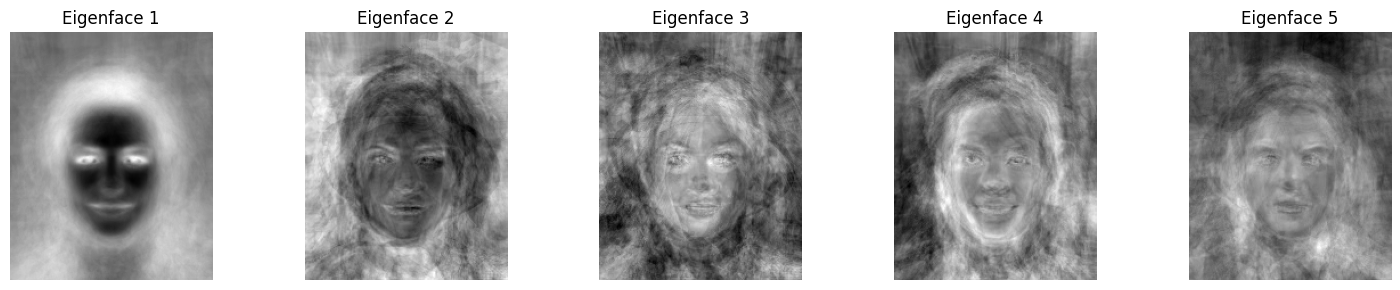

In [13]:
import matplotlib.pyplot as plt

# Flatten the images and create the D matrix
# Each image becomes a column
D = np.array([img.flatten() for img in images]).T

# Compute the covariance matrix in the reduced space
# This is much smaller than D @ D^T for N << M
C = D.T @ D

# Solve the eigenvalue problem
eigenvalues, eigenvectors = np.linalg.eig(C)

# Sort the eigenvalues and eigenvectors in descending order
sorted_indices = np.argsort(eigenvalues)[::-1]
eigenvalues = eigenvalues[sorted_indices]
eigenvectors = eigenvectors[:, sorted_indices]

# Compute the eigenvectors of the original covariance matrix
eigenvectors = D @ eigenvectors

# Display the first five eigenfaces
# Width, height in inches for the entire figure of 5 faces
plt.figure(figsize=(15, 3))

for i in range(5):
    eigenface = eigenvectors[:, i].reshape(images[0].shape)
    ax = plt.subplot(1, 5, i + 1)         # 1 row, 5 columns, ith subplot
    ax.imshow(eigenface, cmap='gray')
    ax.set_title(f'Eigenface {i+1}')
    ax.axis('off')                        # Hide the axis

plt.tight_layout()
plt.show()

### 2.3 - Sliding window method to detect faces
Use a sliding window method to detect faces in the image2, which is named Person.png under folder Q2 part2. Use the result from the previous step to compute the distance in the eignspace between the window contents and your training data.

* Took too long to run, ran out of GPU on colab *

In [23]:
# Load the image
image2 = cv2.imread(os.path.join(path, 'Q2 part2', 'Person.png'), cv2.IMREAD_GRAYSCALE)

# Define the window size
window_size = (100, 100)

# Initialize the list to store the distances
distances = []

# Iterate over the image with a sliding window
for y in range(image2.shape[0] - window_size[1] + 1):
    for x in range(image2.shape[1] - window_size[0] + 1):
        # Extract the window
        window = image2[y:y + window_size[1], x:x + window_size[0]]

        # Flatten the window
        window_flattened = window.flatten().reshape(-1, 100)

        # Compute the distance in the eigenspace
        distance = np.linalg.norm(eigenvectors @ window_flattened - D.mean(axis=1).reshape(-1, 1))

        # Store the distance
        distances.append(distance)

# Find the window with the smallest distance
min_distance = np.min(distances)
min_index = np.argmin(distances)

# Get the coordinates of the window with the smallest distance
y_min, x_min = min_index // (image2.shape[1] - window_size[0] + 1), min_index % (image2.shape[1] - window_size[0] + 1)

# Draw a rectangle around the detected face
cv2.rectangle(image2, (x_min, y_min), (x_min + window_size[0], y_min + window_size[1]), (0, 255, 0), 2)

# Display the image with the detected face
plt.imshow(image2, cmap='gray')
plt.title('Detected Face')
plt.show()

ValueError: shapes (5,) and (38804,2500) not aligned: 5 (dim 0) != 38804 (dim 0)

### 2.4 - Set a threshold
Set a threshold to detect faces and select the best-performed value. Show your fine-tuned process.

### 2.5 - Box faces
Label the detected images with bound boxes and display the final result image with labels.

### 2.6 - Viola-Jones face detector
Use an existing implementation of the Viola-Jones face detector to detect faces on the same image. Compare the result with the method you implemented.

Ref: Tutorial 5

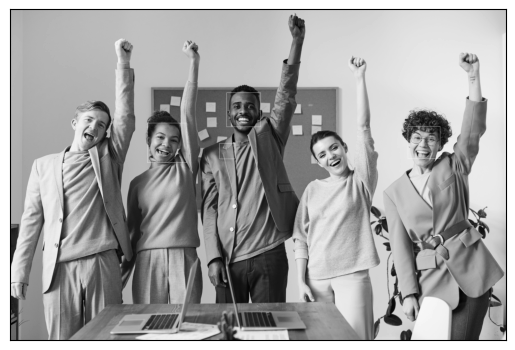

In [31]:
face_detector = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

# Load the image
image = cv2.imread(os.path.join(path, 'Q2 part2', 'Person.png'))

# Convert the image to grayscale
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# detecMutliScale
#   Params: image – Matrix of the type CV_8U containing an image where objects are detected.
#           scaleFactor (1.1) – Parameter specifying how much the image size is reduced at each image scale.
#           minNeighbors (3) – Parameter specifying how many neighbors each candidate rectangle should have to retain it.
#           minSize (0,0) – Minimum possible object size. Objects smaller than that are ignored.
#           maxSize (0,0) – Maximum possible object size. Objects larger than that are ignored.

# Detect faces in the image
faces = face_detector.detectMultiScale(gray, 1.3, 5)

# Draw rectangles around the detected faces
for (x,y,w,h) in faces:
    gray = cv2.rectangle(gray,(x,y),(x+w,y+h),(255,0,0),2)

plt.imshow(gray, cmap="gray")
plt.xticks(())
plt.yticks(())
plt.show()

### 2.7 - Evaluate predicted result
Evaluate your predicted result in both methods (True/False, Positive/Negative).

* True Positives (TP): The number of faces correctly identified by the model.
* False Positives (FP): The number of non-face areas incorrectly identified as faces by the model.
* False Negatives (FN): The number of actual faces that the model failed to detect.

**Note:** True Negatives (TN) are not typically calculated because the notion of a "negative" (i.e., areas where faces are correctly identified as not being present) is vast and not explicitly defined.

Number of faces in "*Person.png*" = 5

For Viola-Jones
* TP = 3
* FP = 1
* FN = 2

### 2.8 - Viola-Jones VS PCA

#### Viola-Jones Detector:

The Viola-Jones detector uses a cascade of classifiers that focus on simple features (like edges, lines, and regions) which are very fast to compute with integral images.
It is particularly effective for frontal face detection in real-time applications and is robust to variations in lighting and skin color.
It performs well in detecting faces with a standard frontal pose but may struggle with faces that are turned at a steep angle, are partially occluded, or have expressions that greatly alter facial features.

#### PCA (Eigenfaces):

PCA-based face detection methods work by comparing the projection of test images into the eigenspace against the projections of known face images.
It requires a well-curated dataset to create a meaningful eigenspace and can be sensitive to alignment and normalization of faces in the dataset.
PCA tends to be less effective with extreme lighting conditions, occlusions, or variations in facial expressions because these factors can significantly alter the principal components.

#### Conditions Where PCA Might Fail:

* Poorly Aligned or Scaled Images: If the faces are not aligned or scaled properly, PCA may not accurately capture the variance in the data.
* Bad Training Data: PCA requires a comprehensive set of training data to capture the variations in facial features effectively.
* Extreme Facial Expressions or Accessories: Faces with unusual expressions, glasses, or hats might introduce significant variance that is not captured in the principal components derived from a more 'neutral' training set.


In summary, the Viola-Jones detector is generally more robust and versatile for different conditions and practical applications, while PCA (Eigenfaces) requires more controlled conditions and thorough pre-processing to function effectively.

Ref: [Source 1](https://www.ripublication.com/acst17/acstv10n5_47.pdf), [Source 2](https://www.researchgate.net/publication/303869142_Face_Detection_and_Recognition_Using_Viola-Jones_with_PCA-LDA_and_Square_Euclidean_Distance), [Source 3](https://www.researchgate.net/publication/373171607_Face_Recognition_Based_on_Viola-Jones_Face_Detection_Method_and_Principle_Component_Analysis_PCA), [Source 4](https://www.ijltemas.in/DigitalLibrary/Vol.8Issue8/110-114.pdf)

### 2.9 - Evaluating Viola-Jones
#### Performance Evaluation

* **Accuracy:** The Viola–Jones algorithm is highly effective at detecting frontal faces. Its accuracy is largely influenced by the quality of the training data and the parameters chosen for the detection process.
* **Speed:** One of the key strengths of Viola–Jones is its speed, which allows for real-time face detection. This is achieved through the use of integral images, which significantly reduce the time needed to compute features.
* **Robustness:** The algorithm is robust against variations in lighting and can detect faces across a range of scales. However, it may struggle with faces that are significantly tilted, partially occluded, or drastically different from the faces in the training data.
* **False Positives/Negatives:** While highly accurate, Viola–Jones can produce false positives and negatives. The rate of these errors depends on the threshold settings for the classifier stages and the diversity of the training dataset.

#### Steps of the Viola–Jones Algorithm

1. **Integral Images:** The algorithm first converts the image into an integral image format. This step allows for the rapid calculation of features by summing the pixel values in rectangular regions.

2. **Feature Selection:** Viola–Jones uses Haar-like features, which are simple contrast features that can be computed quickly thanks to the integral image representation. The features are selected based on their ability to distinguish faces from the background.

3. **AdaBoost Training:** The algorithm employs AdaBoost (Adaptive Boosting) to select a small number of critical features from a larger set and to train the classifier. AdaBoost focuses on difficult-to-classify examples, improving the classifier's performance.

4. **Cascade of Classifiers:** Instead of applying all features to every part of the image, Viola–Jones uses a cascade approach. Simple classifiers eliminate most negative (non-face) windows rapidly, while more complex classifiers are applied in subsequent stages to more promising regions. This significantly reduces computation time.

5. **Scaling for Multi-Scale Detection:** The algorithm uses an image pyramid to detect faces at various sizes. The cascade classifier is applied to each scale, enabling the detection of faces regardless of their size in the image.

6. **Final Detection:** The regions that pass through all stages of the cascade are marked as faces. The algorithm may use techniques like merging overlapping detections to produce the final output.

Ref: [Source 1](https://medium.com/@aaronward6210/facial-detection-understanding-viola-jones-algorithm-116d1a9db218), [Source 2](https://towardsdatascience.com/viola-jones-algorithm-and-haar-cascade-classifier-ee3bfb19f7d8), Sources from 2.8